In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
from skimage.io import imread
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import IncrementalPCA
from sklearn_projects.image_processing.quickdraw.imagebuilder \
    import QuickDrawImageBuilder as ImageBuilder

# Quickdraw Dataset Analysis.

This is an exploratory notebook for the QuickDraw Sketches dataset available from the
Google Creative Lab, and taken from Kaggle (data source and documentation
[here](https://www.kaggle.com/google/tinyquickdraw)).

## Goals of this notebook.

One of the main goals of this notebook and `quickdraw/imagebuilder.py` is to generate
.png files from the raw quickdraw data for use in other ML projects. We will also do some
data exploration (dimensionality reduction through PCA) and visualization.

## Notes on the data format.

According to the
[original data source](https://github.com/googlecreativelab/quickdraw-dataset#the-raw-moderated-dataset),
the 'drawing' key in each data sample has the format

[ [ <br>
    [x0, x1, x2, ...], <br>
    [y0, y1, y2, ...] <br>
   ], <br>
   [ <br>
    [x0, x1, x2, ...], <br>
    [y0, y1, y2, ...] <br>
   ], <br>
   ... ], <br>
Where each [x] and [y] vector correspond to the x and y locations of the current stroke, and
all strokes in the sample are combined in series to form the image. The images are scaled to
a range of [0, 255].

## Read a file in and get meta-data for drawing samples.

First, we will save images created from the drawing data to an output directory.
For now, let's extract data for hedgehogs, bees, birds, cats, cacti, and ants.
We only need to do this once, so set `extract_data`
to `False` in this cell once you've extracted these images to disk. Note that we are only considering
drawings that were marked as "recognized" in the source data by default. We use the
`QuickDrawImageBuilder` class for this extraction; see `sklearn_projects/image_processing/lib/imagebuilder.py`
for details.

In [2]:
################
# read in a file
################
# whether to extract the data. Set to False if you've already extracted the data.
extract_data = True
# location of input data on disk
path_to_data = 'D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/'
# names of data files we want to extract images for
data_names = ['cat'] # ['hedgehog', 'bee', 'bird', 'cactus', 'cat', 'ant']
# maximum number of samples to take per data file.
max_images = 80000
# image dimension (pixels)
image_scale = 64
################

In [3]:
################
# extract data
################
if extract_data:
    for data_name in data_names:
        test_data_file = '{}.ndjson'.format(data_name)
        input_path = path_to_data + test_data_file
        output_path = 'D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/' \
        + 'output_images/{}'.format(data_name)
        print()
        # read and save data...
        ib = ImageBuilder(input_path, output_path,
                          max_images=max_images,
                          image_scale=image_scale)  # set max_images to an int to limit outputs to that many images per category
        ib.build_images()
        ib = None
else:
    print('Skipping data extraction.')




WARNING! Output path D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/output_images/cat already exists. 
 .... Data in this directory will be overwritten.
Image samples: 123202. Extracting the first 80000.
Saved image metadata to D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/output_images/cat/meta/meta.csv.
Ignoring unrecognized images: True

Saved output data to D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/output_images/cat
Output data format: .png
Total images extracted: 66918.


## Vizualize some sample drawings.

Drawings are provided as series of strokes. Here we can simply add them to visualize the final
image input.

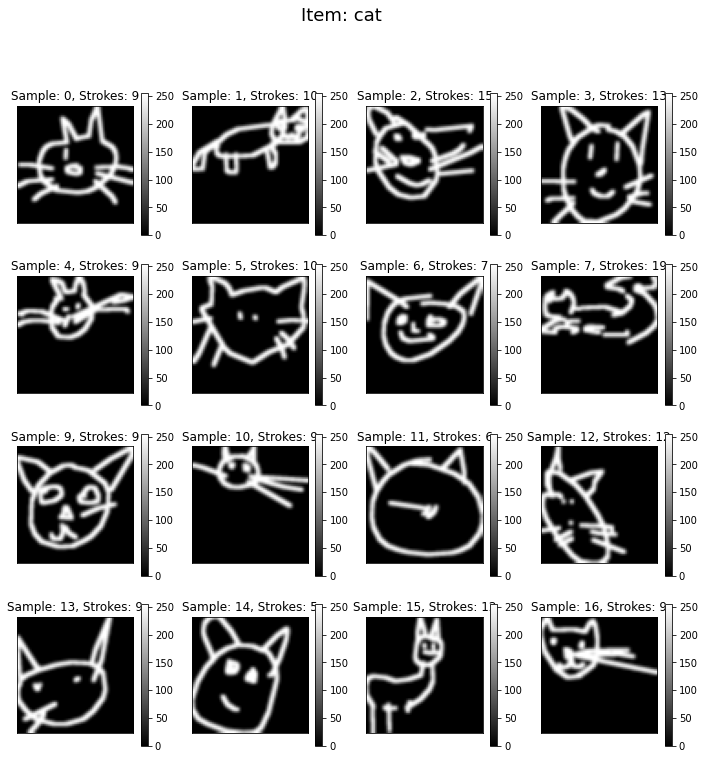

In [4]:
for data_name in data_names:

    # data location
    image_path = path_to_data + 'output_images/' + data_name + '/images/'

    # meta file
    meta_df = pd.read_csv(path_to_data + 'output_images/' + data_name + '/meta/meta.csv')
    # print(meta_df['recognized'].value_counts())

    # get image indices of recognized images:
    image_indices = meta_df[meta_df['recognized']==True]['sample_id'].values.tolist()

    plt.figure(figsize=(12,12))
    for plot_index, sample_id in enumerate(image_indices[:16]):
        sample = imread(image_path+'{}{}.png'.format('sample',
                                                     sample_id),
                        as_gray=True)
        plt.subplot(4,4,plot_index+1)
        plt.imshow(sample,
                   cmap='gray')
        plt.xticks([])
        plt.yticks([])
        num_strokes = meta_df[meta_df['sample_id'] == sample_id]['num_strokes'].values.tolist()[0]
        plt.title('Sample: {}, Strokes: {}'.format(sample_id, num_strokes))
        plt.colorbar()
    plt.suptitle('Item: {}'.format(data_name),
                 fontsize=18)
    plt.show();

## PCA for each data type.

Let's visualize the principle components for each of these data types.

We will use
[Incremental PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html)
for this. Let's take the top 100 components and see how much of the image variance
we can explain. Also note that, to save time for now, we are only fitting these
PC models to a small subset of the input data.

In [8]:
###################
# number of components to extract
ipca_components = 100
# number of images in each IPCA batch
ipca_batch_size = 500
# dict to store IPCA transforms as they are fit
IPCA_transforms = {}
###################

# define plotting function:
def plot_pca(batch):
    clear_output(wait=True)
    plt.figure(figsize=(24,24))
    for pca_component in range(ipca_components)[:64]:
        plt.subplot(8,8,pca_component+1)
        plt.imshow(np.reshape(IPCA_transforms[data_name].components_[pca_component],
                              (image_scale,image_scale)),
                   cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title('Comp. {}'.format(pca_component+1),
                  fontsize=18)
    plt.suptitle('Data: {},\nExp. Var. Ratio: {:.5f},\nBatches: {}.'.format(data_name,
                                                                        sum(IPCA_transforms[data_name].explained_variance_ratio_),
                                                                        batch),
                 fontsize=22)
    plt.show();
    return

# define IPCA loop:
def run_ipca(data_name):
    IPCA_transforms[data_name] = IncrementalPCA(n_components=ipca_components,
                                                batch_size=ipca_batch_size)
    # data location
    image_path = path_to_data + 'output_images/' + data_name + '/images/'

    # meta file
    meta_df = pd.read_csv(path_to_data + 'output_images/' + data_name + '/meta/meta.csv')
    # print(meta_df['recognized'].value_counts())

    # get image indices of recognized images:
    image_indices = meta_df[(meta_df['recognized']==True)
                            & (meta_df['sample_id']< max_images)]['sample_id'].values.tolist()
    num_images = len(image_indices)
    # num_images = len([name for name in os.listdir(image_path)
    #                   if name[-3:] == 'png'])

    print('Data: {}.'.format(data_name))
    print('Number of images: {}.'.format(num_images))
    ipca_batches = int(np.floor(num_images/ipca_batch_size))
    print('IPCA Batches: {}.'.format(ipca_batches))
    print('Number of components: {}.'.format(ipca_components))

    # perform IPCA (reduced to only first 21 batches for testing for now)
    for batch in tqdm(range(ipca_batches)[:51], desc='IPCA for {}'.format(data_name)):
        img_batch = [imread(image_path+'sample{}.png'.format(image_indices[sample_id]),
                            as_gray=True)/255.
                     for sample_id
                     in range(int(batch*ipca_batch_size),
                              min(num_images,int((batch+1)*ipca_batch_size)))]
        img_batch = np.array([img.flatten() for img in img_batch])
        IPCA_transforms[data_name].partial_fit(img_batch)
        if batch%10 == 0 and batch > 0:
            # print('    Explained Variance: {:.5f}'.format(
            #     sum(IPCA_transforms[data_name].explained_variance_ratio_)))
            plot_pca(batch)

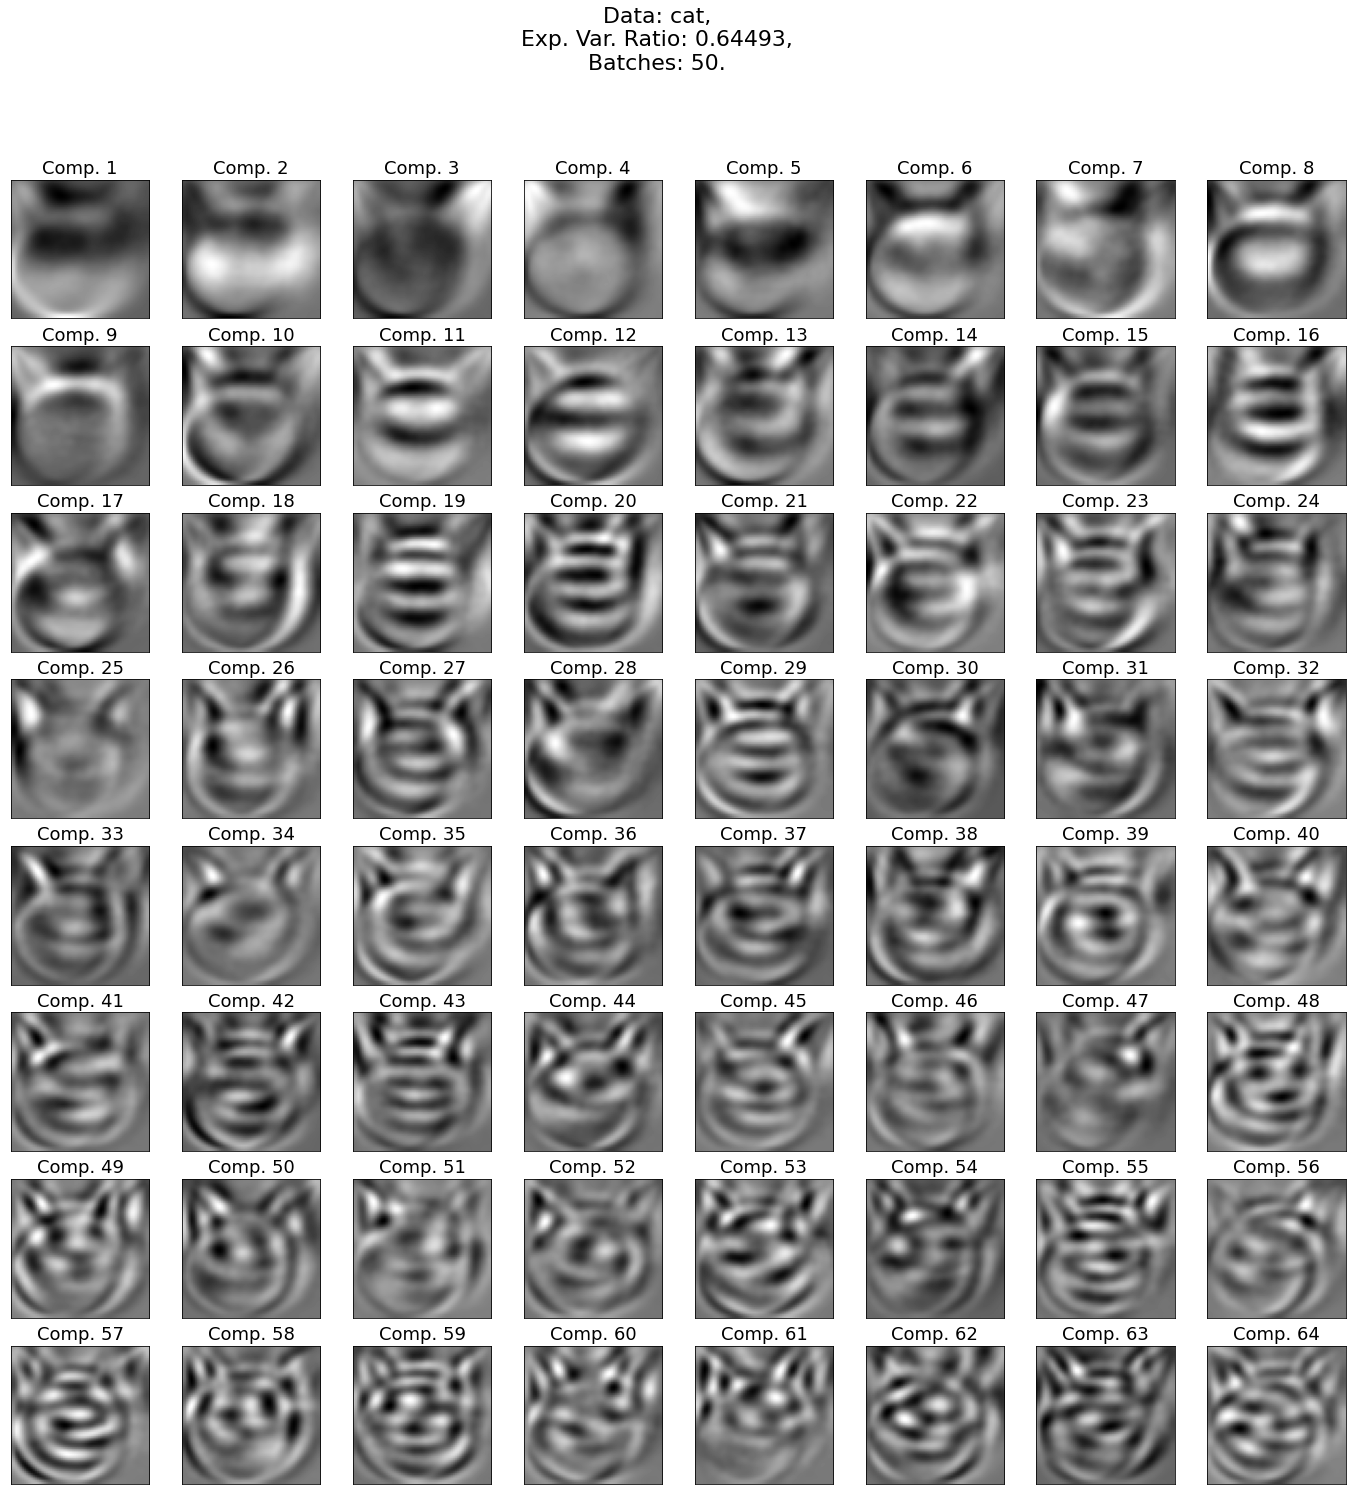

In [9]:
data_name = data_names[0]
run_ipca(data_name)

In [ ]:
# data_name = data_names[1]
# run_ipca(data_name)

In [ ]:
# data_name = data_names[2]
# run_ipca(data_name)

In [ ]:
# data_name = data_names[3]
# run_ipca(data_name)

In [ ]:
# data_name = data_names[4]
# run_ipca(data_name)

In [ ]:
# data_name = data_names[5]
# run_ipca(data_name)

## So what can we see from these preliminary PC responses?

Well, it looks like low-frequency information is captured in the most important principal
components, with high-frequency information represented in successively higher components.
This is typical. Unfortunately, at least for the data sampled to train these PC transforms,
we do not seem to be capturing much of the total data variance in even the first 100 components.
Still, projections onto PC's may be useful features to consider for, say, classification
or generative problems.